# Data cleaning

This notebook shows all the data cleaning steps. It has to be run once to obtain the cleaned data.

### Movie data 
<b>Why 3 datasets ?</b> \
For our purpose, we need movie data and corresponding movie plots. We will restrict the analysis to American movies, leaving us with approximately half of the original dataset — 20,788 movies. \\
Since we will try to assess the correlation of the data with historical events, the release date is really important. We want to have the precise date, not just the year. However, dropping all rows where the date is not precise will cause us to lose a lot of data, as only 13,335 movies have precise dates. This is where the Kaggle dataset comes in. When the date is not precise, we will try to match the movie with this dataset and extract its date. Using this method, we recover a lot of data and end up with 17,077 movies.

<b>Data preprocessing steps</b> \
We will apply the following pipeline:

<ul>
    <li>load CMU, plots and Kaggle datasets </li>
    <li>CMU data preprocessing</li><ul>
        <li>Remove unnecessary columns</li>
        <li>Check for NaN values in plots</li>
        <li>Merge CMU metadata and plots on Wikipedia ID — take only movies present in both</li>
        <li>Convert plots to lowercase</li>
        <li>Put each column of the movie metadata in the correct format. For example, {"/m/09c7w0": "United States of America"} should become "United States of America"</li>
        <li>Keep only American movies</li>
    </ul>
    <li>Kaggle data preprocessing</li><ul>
        <li>Remove unnecessary columns</li>
        <li>Put each column of the movie metadata in the correct format. For example, {"/m/09c7w0": "United States of America"} should become "United States of America"</li>
        <li>Keep only American movies</li>
        <li>Drop NaN values and duplicated rows (if present)</li>
    </ul>
    <li>For incomplete or missing dates, merge with the Kaggle dataset using the movie title, and ultimately the date</li>
    <li>Check for outliers (e.g., incorrect dates)</li>
    <li>Save the cleaned dataset</li>
</ul>


### Labelled data

For your project, we needed to assign to each movie a violence level. We therefore performed a human-labelling steps to create a training/validation set. This data also need to be cleaned.

<b>Data preprocessing steps</b> \
We will apply the following pipeline:

<ul>
    <li>load The data</li>
    <li>Assess the subjectivity of the data</li>
    <li>Make each label unique</li>
    <li>Save the data</li>
</ul>

## Imports

In [35]:
import sys
import os
import re
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [36]:
# Add the project root directory (not src) to sys.path
sys.path.append(os.path.abspath("../data/"))

# Now import the DataLoader class
from data_loading import DataLoader

raw = '../../data/RAW/'
clean = '../../data/CLEAN'

# Movie data

## Load the data

In [37]:
#loader
data_loader = DataLoader(raw,clean)
#load raw data
CMU_movie_metadata,CMU_plot_summary,GVD_data,Kaggle_movies_metadata = data_loader.load_all_data()


load CMU movie metadata


load plot data


load GVD data


load kaggle movie data



## CMU metadata and plot data

In [38]:
CMU_movie_metadata

,Freebase movie ID,Movie name,Release date,Box office revenue,Runtime,Languages,Countries,Genres
Wikipedia movie ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...
35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"


In [39]:
CMU_plot_summary

,Plot
Wikipedia movie ID,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...
...,...
34808485,"The story is about Reema , a young Muslim scho..."
1096473,"In 1928 Hollywood, director Leo Andreyev look..."
35102018,American Luthier focuses on Randy Parsons’ tra...


In [40]:
#drop unnecessary columns in metadata
CMU_movie_metadata.drop(['Freebase movie ID', 'Runtime'], axis=1,inplace=True)

In [41]:
#check for NAN
CMU_plot_summary[CMU_plot_summary["Plot"].isna()]

,Plot
Wikipedia movie ID,


In [42]:
#merge the two datasets
Movie_Data = CMU_movie_metadata.merge(CMU_plot_summary,left_index=True, right_index=True, how='inner')

In [43]:
# Lower case the plot_summaries
Movie_Data['Plot'] = Movie_Data['Plot'].str.lower()

In [44]:
# put genres, countries and languages in an understandable format
def extract_data(text):
    # Find all matches for names using a regex pattern that matches quoted text after colon
    return ', '.join(re.findall(r'": "([^"]+)"', text))

for name in ['Genres','Countries','Languages'] :
    Movie_Data[name] = Movie_Data[name].apply(extract_data)

In [45]:
Movie_Data["Countries"].value_counts() #majority of american movies

Countries
United States of America                                        17774
India                                                            4628
                                                                 3312
United Kingdom                                                   2284
Japan                                                            1157
                                                                ...  
France, Austria, Iraq, Iran                                         1
United States of America, Serbia, Germany                           1
South Africa, Ireland, United Kingdom                               1
France, Australia, United Kingdom, Germany                          1
Yugoslavia, Socialist Federal Republic of Yugoslavia, Serbia        1
Name: count, Length: 1501, dtype: int64

In [46]:
# only american movies
Movie_Data = Movie_Data[Movie_Data['Countries'].str.contains("United States of America", na=False)]
Movie_Data.shape

(20788, 7)

In [47]:
#shape before any drop for dates
Movie_Data.shape

(20788, 7)

In [48]:
#find all movies where the date format is wrong
Movie_Data_date_wrong = Movie_Data[~Movie_Data['Release date'].str.match(r'^\d{4}-\d{2}-\d{2}$', na=False)]

In [49]:
# number of remaining datapoint if we drop all row where the date format is wrong
Movie_Data.shape[0]-Movie_Data_date_wrong.shape[0]

13335

## Kaggle metadata

In [50]:
Kaggle_movies_metadata

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [51]:
# Keep only the rows of interest
Kaggle_movies_metadata = Kaggle_movies_metadata[["production_countries","release_date","title","revenue","vote_count","vote_average","popularity","budget"]]

In [52]:
# majority from US
Kaggle_movies_metadata['production_countries'].value_counts()

production_countries
[{'iso_3166_1': 'US', 'name': 'United States of America'}]                                                                                    17851
[]                                                                                                                                             6282
[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]                                                                                               2238
[{'iso_3166_1': 'FR', 'name': 'France'}]                                                                                                       1654
[{'iso_3166_1': 'JP', 'name': 'Japan'}]                                                                                                        1356
                                                                                                                                              ...  
[{'iso_3166_1': 'CZ', 'name': 'Czech Republic'}, {'iso_3166_1': 'DE', 'name': 'Germany'}, {

In [53]:
# extract country of production for the kaggle dataset
def extract_country(text):
    final_countries = ""
    countries = ast.literal_eval(Kaggle_movies_metadata.production_countries[0])
    for country in countries :
        final_countries = final_countries + " " + country['name']
    return final_countries 

Kaggle_movies_metadata.loc[:, 'production_countries'] = Kaggle_movies_metadata['production_countries'].apply(extract_country)

In [54]:
# only american movies
Kaggle_movies_metadata = Kaggle_movies_metadata[Kaggle_movies_metadata['production_countries'].str.contains("United States of America", na=False)]
Kaggle_movies_metadata.shape

(45466, 8)

In [55]:
# drop NAN
Kaggle_movies_metadata.dropna(inplace=True)
Kaggle_movies_metadata.shape

(45376, 8)

In [56]:
# drop full duplicates
Kaggle_movies_metadata.drop_duplicates()
Kaggle_movies_metadata.shape

(45376, 8)

## Handle the movie name duplicate and the date problem

In [57]:
Movie_Data[Movie_Data["Movie name"] == "Dr. Jekyll and Mr. Hyde"]

,Movie name,Release date,Box office revenue,Languages,Countries,Genres,Plot
Wikipedia movie ID,,,,,,,
7884497,Dr. Jekyll and Mr. Hyde,1913-03-06,NaN,English Language,United States of America,"Short Film, Science Fiction, Horror, Black-and...","dr. henry jekyll sends a note to his fiancée,..."
7883633,Dr. Jekyll and Mr. Hyde,1920-04,NaN,"Silent film, English Language",United States of America,"Silent film, Horror, Indie, Science Fiction, B...",at the first transformation starts with jekyll...
144774,Dr. Jekyll and Mr. Hyde,1931-12-31,NaN,English Language,United States of America,"Science Fiction, Horror, Black-and-white, Dram...","the film tells the story of dr. henry jekyll ,..."
3672796,Dr. Jekyll and Mr. Hyde,1920-03-18,NaN,"Silent film, English Language",United States of America,"Crime Fiction, Silent film, Horror, Science Fi...","henry jekyll is a doctor of medicine, but he ..."
2490751,Dr. Jekyll and Mr. Hyde,1941-08-12,1279000.0,English Language,United States of America,"Science Fiction, Horror, Black-and-white",dr. jekyll believes good and evil exist in ev...
7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,NaN,Silent film,United States of America,"Short Film, Silent film, Horror, Indie, Black-...",dr. jekyll and mr. hyde began with the raising...
7856323,Dr. Jekyll and Mr. Hyde,1912-01-16,NaN,English Language,United States of America,"Short Film, Horror, Black-and-white",james cruze's white-haired dr. jekyll has secr...


In [58]:
Kaggle_movies_metadata[Kaggle_movies_metadata["title"] == "Dr. Jekyll and Mr. Hyde"]

,production_countries,release_date,title,revenue,vote_count,vote_average,popularity,budget
7055,United States of America,1941-08-12,Dr. Jekyll and Mr. Hyde,0.0,31.0,6.6,2.225578,0
7823,United States of America,1931-12-31,Dr. Jekyll and Mr. Hyde,0.0,56.0,7.3,4.749049,0
8294,United States of America,1920-03-18,Dr. Jekyll and Mr. Hyde,0.0,26.0,6.8,1.562169,0
25134,United States of America,2008-05-17,Dr. Jekyll and Mr. Hyde,0.0,7.0,4.2,0.911584,0


as we can see, some nome are similar in both dataset, but there is no duplicate. They are different movies. 

We will take that into account for the date algorithm. 

In [59]:
#iter on all row of the wrong date dataset
for index, row in Movie_Data_date_wrong.iterrows() :
    # is it in the kaggle dataset ?
    kaggle_data = Kaggle_movies_metadata[Kaggle_movies_metadata["title"] == row["Movie name"]]
    
    #if not, drop the row
    if kaggle_data.empty :
        #print("drop")
        Movie_Data.drop([index], inplace=True)

    #if yes and only ones, extract the date
    elif kaggle_data.shape[0] == 1 :
        #print("change")
        Movie_Data.loc[index,"Release date"] = kaggle_data.iloc[0]["release_date"]

    #if multiple movies have this name in the kaggle dataset, compare with the incomplete date of the CMU dataset
    else :
        date = Movie_Data_date_wrong.loc[index, "Release date"]

        #if not the same year and not the year in the CMU, drop
        if pd.isna(date) or len(date) < 4 :
            Movie_Data.drop([index],inplace=True)

        #else, compare
        else :
            kaggle_data = kaggle_data[kaggle_data['release_date'].str[:4] == date[0:4]]

            #found only 1 movie this year ? extract the date !
            if kaggle_data.shape[0] == 1 :
                #print("found!")
                Movie_Data.loc[index,"Release date"] = kaggle_data.iloc[0]["release_date"]

            #give up
            else :
                #print("sad..")
                Movie_Data.drop([index], inplace=True)

In [60]:
Movie_Data #nice we kept 4000 more data !!

,Movie name,Release date,Box office revenue,Languages,Countries,Genres,Plot
Wikipedia movie ID,,,,,,,
975900,Ghosts of Mars,2001-08-24,14010832.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...","set in the second half of the 22nd century, th..."
6631279,Little city,1997-04-04,NaN,English Language,United States of America,"Romantic comedy, Ensemble Film, Comedy-drama, ...","adam, a san francisco-based artist who works a..."
77856,Mary Poppins,1964-08-27,102272727.0,English Language,United States of America,"Children's/Family, Musical, Fantasy, Comedy, D...",the film opens with mary poppins perched in a...
21926710,White on Rice,2009-05-31,NaN,,United States of America,"Romantic comedy, Romance Film, Comedy, Indie",jimmy ([[hiroshi watanabe loves dinosaurs and...
156558,Baby Boy,2001-06-27,29381649.0,English Language,United States of America,"Crime Fiction, Drama, Coming of age",a young 20-year-old named jody lives with his...
...,...,...,...,...,...,...,...
25011340,Dot.Kill,2005-03-08,NaN,,United States of America,"Thriller, Crime Thriller, Action, Psychologica...","charlie daines , is a morphine-addicted detect..."
7761830,Spaced Invaders,1990-04-27,15369573.0,English Language,United States of America,"Alien Film, Science Fiction, Family Film, Come...","the space armada from mars, known as the imper..."
1918494,State and Main,2000-08-26,6944471.0,"Italian Language, English Language","France, United States of America","Parody, Americana, Comedy",havoc is wrought on the inhabitants of a small...


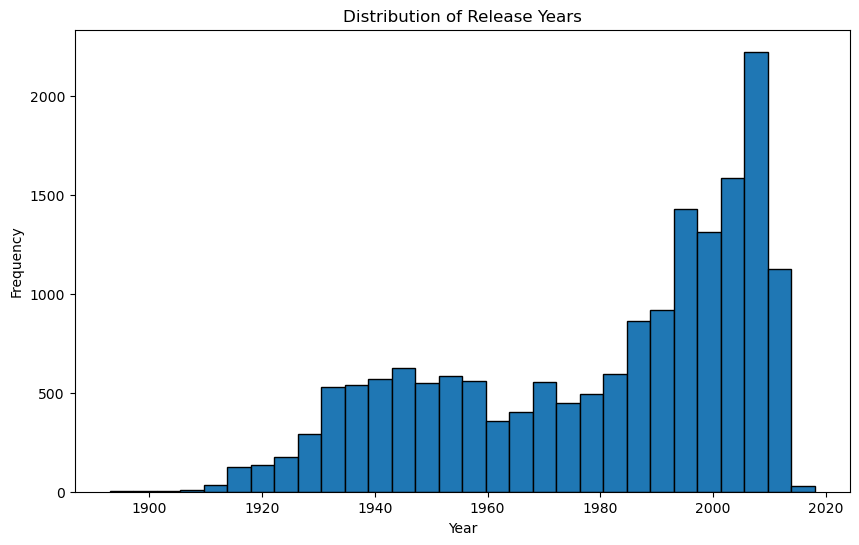

In [61]:
Date = Movie_Data["Release date"].str[:4].astype(int)
plt.figure(figsize=(10, 6))
plt.hist(Date, bins=30, edgecolor='black')
plt.title('Distribution of Release Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

#look nice ! no outliers :)

In [62]:
#save the data 
Movie_Data.to_csv(clean+"/Movie_Data_clean.tsv", sep="\t")

There are 780 unique box office revenues in wrong date


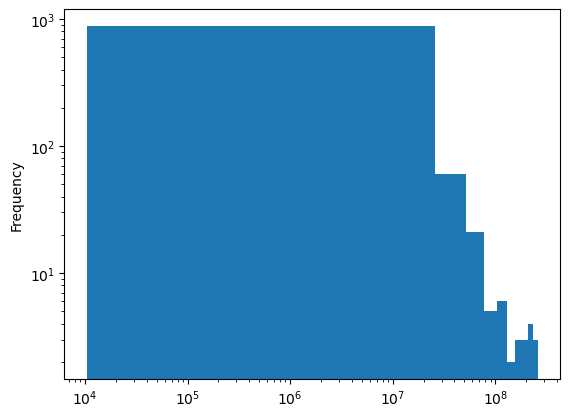

In [63]:
Movie_Data_date_wrong["Box office revenue"].plot(kind="hist",loglog=True)
print("There are {} unique box office revenues in wrong date".format(len(Movie_Data_date_wrong["Box office revenue"].unique())))

There are 5451 unique revenues in filtered CMU movies
There are 10968 nan revenues in Kaggle movies
Only 31.920126% movies have unique value


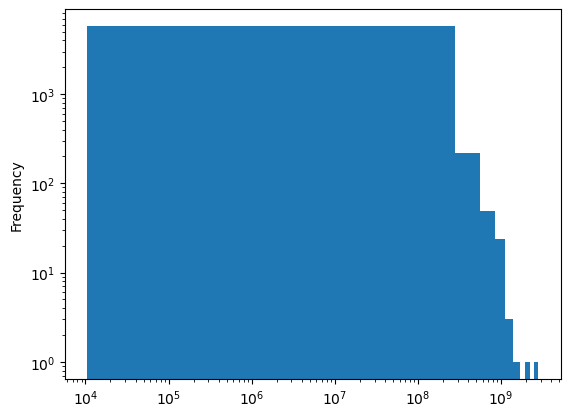

In [64]:
Movie_Data["Box office revenue"].plot(kind="hist",loglog=True)
print("There are {} unique revenues in filtered CMU movies".format(len(Movie_Data["Box office revenue"].unique())))
print("There are {} nan revenues in Kaggle movies".format(len(Movie_Data["Box office revenue"][Movie_Data["Box office revenue"].isna()==True])))
print("Only {:%} movies have unique value".format(len(Movie_Data["Box office revenue"].unique())/len(Movie_Data["Box office revenue"])))

There are 6863 unique revenues in Kaggle movies
There are 45376 nan revenues in Kaggle movies
Only 15.124736% movies have unique value


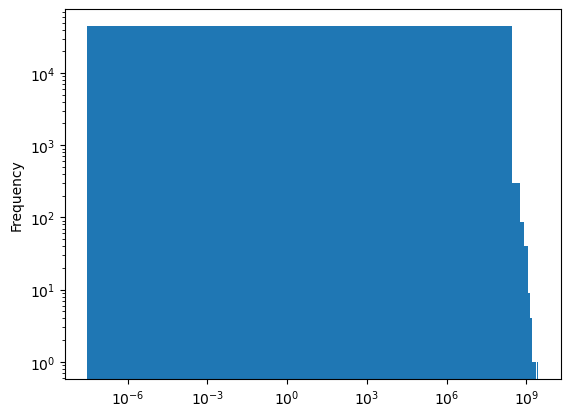

In [65]:
Kaggle_movies_metadata.revenue.plot(kind="hist", loglog=True)
print("There are {} unique revenues in Kaggle movies".format(len(Kaggle_movies_metadata.revenue.unique())))
print("There are {} nan revenues in Kaggle movies".format(len(Kaggle_movies_metadata[Kaggle_movies_metadata.isna()==True])))
print("Only {:%} movies have unique value".format(len(Kaggle_movies_metadata.revenue.unique())/len(Kaggle_movies_metadata)))

In [66]:
CMU_nan_budget = Movie_Data[Movie_Data["Box office revenue"].isna()]
print("There are {} movies that don't have information about their revenue".format(len(CMU_nan_budget)))
print("If we would to drop them, it would result in a loss of {:%} american movies.".format(len(CMU_nan_budget)/len(Movie_Data)))
# Let's try to complete it 

There are 10968 movies that don't have information about their revenue
If we would to drop them, it would result in a loss of 64.226738% american movies.


In [67]:
# Fill the nan by 0 to ensure proper handling later on 
Movie_Data["Box office revenue"] =Movie_Data["Box office revenue"].fillna(0) 
Kaggle_movies_metadata.revenue = Kaggle_movies_metadata.revenue.fillna(0)

In [68]:
# #iter on all dataset whethever having the value of box-office or not 

# counter_same = 0
# counter_multiple = 0
# counter_stay_same = 0
# counter_diff = 0 
# counter_less_than_1 = 0
# diff_revenue = pd.DataFrame(columns=["Title","CMU_revenue", "Kaggle_revenue", "Diff","Percentage"])


# for index, row in Movie_Data.iterrows() :
#     # is it in the kaggle dataset ?
#     kaggle_data = Kaggle_movies_metadata[Kaggle_movies_metadata["title"] == row["Movie name"]]
    

#     #if yes and only ones 
#     if kaggle_data.shape[0] == 1 :

#         if (kaggle_data.iloc[0]["revenue"] != 0) and (Movie_Data.loc[index, "Box office revenue"] != 0):
#             if  kaggle_data.iloc[0]["revenue"] == Movie_Data.loc[index, "Box office revenue"]: 
#                 counter_same += 1
#                 #print("Revenue matched :) ")
            
#             else: 
#                 # print("There is a difference of {}".format(np.abs(kaggle_data.iloc[0]["revenue"]-Movie_Data.loc[index, "Box office revenue"])))
#                 # print("Kaggle being {}".format(kaggle_data.iloc[0]["revenue"]))
#                 # print("CMU being {}".format(Movie_Data.loc[index, "Box office revenue"]))
#                 Percentage_diff = np.abs(kaggle_data.iloc[0]["revenue"]-Movie_Data.loc[index, "Box office revenue"])/(kaggle_data.iloc[0]["revenue"]+Movie_Data.loc[index, "Box office revenue"])
#                 new_row = pd.DataFrame({"Title": [row["Movie name"]], "CMU_revenue": [Movie_Data.loc[index, "Box office revenue"]],"Kaggle_revenue":[kaggle_data.iloc[0]["revenue"]], "Diff": np.abs(kaggle_data.iloc[0]["revenue"]-Movie_Data.loc[index, "Box office revenue"]), "Percentage": Percentage_diff})
#                 diff_revenue = pd.concat([diff_revenue, new_row], ignore_index=True)
#                 counter_diff += 1
#                 if Percentage_diff < 0.001:
#                     counter_less_than_1 += 1
#                 else: #if multiple movies have this name in the kaggle dataset, compare with the incomplete date of the CMU dataset
#                     counter_multiple += 1
#                     date = Movie_Data.loc[index, "Release date"]
#                     #if not the same year and not the year in the CMU, drop
#                     if pd.isna(date) or len(date) < 4 :
#                         Movie_Data.drop([index],inplace=True)

#                     #  else, compare
#                     else :
#                         kaggle_data = kaggle_data[kaggle_data['release_date'].str[:4] == date[0:4]]
#                     #found only 1 movie this year ? extract the date !
#                         if kaggle_data.shape[0] == 1 :
#                             if  kaggle_data.iloc[0]["revenue"] == Movie_Data.loc[index, "Box office revenue"]: 
#                                 counter_same += 1
#                             else: 
#                                 counter_diff += 1
#                                 Percentage_diff = np.abs(kaggle_data.iloc[0]["revenue"]-Movie_Data.loc[index, "Box office revenue"])/(kaggle_data.iloc[0]["revenue"]+Movie_Data.loc[index, "Box office revenue"])
#                                 new_row = pd.DataFrame({"Title": [row["Movie name"]], "CMU_revenue": [Movie_Data.loc[index, "Box office revenue"]],"Kaggle_revenue":[kaggle_data.iloc[0]["revenue"]], "Diff": np.abs(kaggle_data.iloc[0]["revenue"]-Movie_Data.loc[index, "Box office revenue"]), "Percentage": Percentage_diff})
#                                 diff_revenue = pd.concat([diff_revenue, new_row], ignore_index=True)
#                                 if Percentage_diff < 0.01:
#                                     counter_less_than_1 += 1

In [69]:
# print("There are {} movies that have less than 1 percents difference".format(counter_less_than_1))
# print("There are {} matching revenues".format(counter_same))   
# print("There are {} mismatched revenues, there is a difference between kaggle and cmu".format(counter_diff))
# print("There are {} unmatch revenues because multiple countries have same title".format(counter_multiple))
# print("There are {} movies that stay the same ".format(counter_stay_same))
# print("There are {} movies that we have the information".format(counter_same+counter_stay_same))
# print("There are {} movies that we have the information taking into account 1 percents difference".format(counter_same+counter_stay_same+counter_less_than_1))

In [70]:
# diff_revenue

In [71]:
# plt.hist(diff_revenue, density=True, bins=30, log=True)
# plt.show()


# Human Labelled data

## Data loading

In [72]:
# #load the labelled data
# ViolentLabel,ViolentData = data_loader.human_labelled_data("Raw")
# display(ViolentLabel)
# display(ViolentData.head())
# # LAST is  boolean to recognize the point we added to help the analysis, more explanation after

## Assess subjectivity and clean the data

Some data have been labelled several times by several people, to assess the subjectivity of the labelling task. \
Let's visualize the data.
Here we will plot only datapoint that have been labelled at least 2 times. 

In [73]:
# DataBefore = ViolentData[ViolentData["LAST"] == 0]
# duplicated_data = DataBefore[DataBefore.index.duplicated(keep=False)]

# # Plot all duplicates in one figure with side-by-side boxplots
# plt.figure(figsize=(12, 6))
# sns.boxplot(data=duplicated_data, x="Wikipedia movie ID", y="Answer")

# # Add labels and title
# plt.title("Box Plot of 'Answer' by Duplicated Wikipedia IDs")
# plt.xlabel("Wikipedia ID")
# plt.xticks(rotation=90)
# plt.ylabel("Answer Value")

# plt.show()

In [74]:
# print("We have",len(DataBefore.index.unique()),"labelled plots")
# print("We have",len(duplicated_data.index.unique()),"duplicated labelling")
# print("We have",(duplicated_data.groupby("Wikipedia movie ID")["Answer"].nunique() > 1).sum(),"datapoint with different labels")

In [75]:
# DataBefore.groupby("Wikipedia movie ID").size().value_counts().sort_index()

The task is more difficult than expected ! \
A majority of duplicated labelling show the same output. However, we have different value for 24 points.
Additionnaly, for 3 points we have the 3 answers ! We will take a closer look to this point and to the point with opposite labels.

In [76]:
# OppositeLabels = duplicated_data.groupby("Wikipedia movie ID").filter( lambda group: set([-1, 1]).issubset(group["Answer"].unique()))

# # Plot all duplicates in one figure with side-by-side boxplots
# plt.figure(figsize=(12, 6))
# sns.swarmplot(data=OppositeLabels, x="Wikipedia movie ID", y="Answer", size=20)

# # Add labels and title
# plt.title("Movie with opposite labels")
# plt.xlabel("Wikipedia ID")
# plt.xticks(rotation=90)
# plt.ylabel("Answer Value")

# plt.show()

In [77]:
# for plot in Movie_Data.loc[OppositeLabels.index.unique()]["Plot"] :
#     display(plot)
#     print("\n\n")

We can distinguish 3 types of datapoints :
- have been labeled multiple times with always the same label : We keep this label.
- have been labeled multiple times with different labels but the mean is closer to 1 label (example 3 labels (0,0,1)) : we could keep the label closest to the mean, we will take a deep look and relabel if necessary.
- have been labeled multiple times with different labels and the mean is exactly between 2 labels : We will take a closer look and re-label by another person.

After relabelling, here is the result

In [78]:
# duplicated_data_clean = ViolentData[ViolentData.index.duplicated(keep=False)]

# # Plot all duplicates in one figure with side-by-side boxplots
# plt.figure(figsize=(12, 6))
# sns.boxplot(data=duplicated_data_clean, x="Wikipedia movie ID", y="Answer")

# # Add labels and title
# plt.title("Box Plot of 'Answer' by Duplicated Wikipedia IDs")
# plt.xlabel("Wikipedia ID")
# plt.xticks(rotation=90)
# plt.ylabel("Answer Value")

# plt.show()

In [79]:
# ViolentData.groupby("Wikipedia movie ID").size().value_counts().sort_index()

In [80]:
# FinalData = ViolentData.groupby("Wikipedia movie ID")["Answer"].median().to_frame()
# FinalData.head()

In [81]:
# FinalData[~FinalData["Answer"].isin([-1, 0, 1])]

The labelling step is done ! We save the data.

In [82]:
# data_loader.save_back_to_excel(ViolentLabel, FinalData)

In [83]:
Movie_Data_autoregressive = Movie_Data.copy()
Movie_Data_autoregressive.drop(columns=["Languages", "Countries",  "Plot"], inplace=True)
Movie_Data_autoregressive


,Movie name,Release date,Box office revenue,Genres
Wikipedia movie ID,,,,
975900,Ghosts of Mars,2001-08-24,14010832.0,"Thriller, Science Fiction, Horror, Adventure, ..."
6631279,Little city,1997-04-04,0.0,"Romantic comedy, Ensemble Film, Comedy-drama, ..."
77856,Mary Poppins,1964-08-27,102272727.0,"Children's/Family, Musical, Fantasy, Comedy, D..."
21926710,White on Rice,2009-05-31,0.0,"Romantic comedy, Romance Film, Comedy, Indie"
156558,Baby Boy,2001-06-27,29381649.0,"Crime Fiction, Drama, Coming of age"
...,...,...,...,...
25011340,Dot.Kill,2005-03-08,0.0,"Thriller, Crime Thriller, Action, Psychologica..."
7761830,Spaced Invaders,1990-04-27,15369573.0,"Alien Film, Science Fiction, Family Film, Come..."
1918494,State and Main,2000-08-26,6944471.0,"Parody, Americana, Comedy"


In [84]:
# Let's take care of the dates to have the (Week - Year) format

Movie_Data_autoregressive["Year"] = pd.to_datetime(Movie_Data["Release date"]).dt.year
Movie_Data_autoregressive["Week"] = pd.to_datetime(Movie_Data["Release date"]).dt.isocalendar().week
Movie_Data_autoregressive

,Movie name,Release date,Box office revenue,Genres,Year,Week
Wikipedia movie ID,,,,,,
975900,Ghosts of Mars,2001-08-24,14010832.0,"Thriller, Science Fiction, Horror, Adventure, ...",2001,34
6631279,Little city,1997-04-04,0.0,"Romantic comedy, Ensemble Film, Comedy-drama, ...",1997,14
77856,Mary Poppins,1964-08-27,102272727.0,"Children's/Family, Musical, Fantasy, Comedy, D...",1964,35
21926710,White on Rice,2009-05-31,0.0,"Romantic comedy, Romance Film, Comedy, Indie",2009,22
156558,Baby Boy,2001-06-27,29381649.0,"Crime Fiction, Drama, Coming of age",2001,26
...,...,...,...,...,...,...
25011340,Dot.Kill,2005-03-08,0.0,"Thriller, Crime Thriller, Action, Psychologica...",2005,10
7761830,Spaced Invaders,1990-04-27,15369573.0,"Alien Film, Science Fiction, Family Film, Come...",1990,17
1918494,State and Main,2000-08-26,6944471.0,"Parody, Americana, Comedy",2000,34


In [85]:
LLM_binary_df = pd.read_csv('../../data/CLEAN/classification_result/LLM_result_binary.csv')
LLM_binary_df

,Wikipedia movie ID,Result,Prediction
0,975900,Violent,1.0
1,6631279,Non-violent,-1.0
2,77856,Non-violent,-1.0
3,21926710,Non-violent,-1.0
4,156558,Violent,1.0
...,...,...,...
17059,25011340,Violent,1.0
17060,7761830,Violent,1.0
17061,1918494,Non-violent,-1.0
17062,664006,Violent,1.0


In [86]:
LLM_binary_df_violent = LLM_binary_df[LLM_binary_df["Prediction"] == 1.0]
LLM_binary_df_violent

,Wikipedia movie ID,Result,Prediction
0,975900,Violent,1.0
4,156558,Violent,1.0
7,4951456,Violent,1.0
10,1369204,Violent,1.0
13,2647998,Violent,1.0
...,...,...,...
17051,25920477,Violent,1.0
17055,11350779,Violent,1.0
17059,25011340,Violent,1.0
17060,7761830,Violent,1.0


In [87]:
Violent_Movies_autoregressive = Movie_Data_autoregressive.merge(LLM_binary_df_violent, how='left', on='Wikipedia movie ID')
Violent_Movies_autoregressive

,Wikipedia movie ID,Movie name,Release date,Box office revenue,Genres,Year,Week,Result,Prediction
0,975900,Ghosts of Mars,2001-08-24,14010832.0,"Thriller, Science Fiction, Horror, Adventure, ...",2001,34,Violent,1.0
1,6631279,Little city,1997-04-04,0.0,"Romantic comedy, Ensemble Film, Comedy-drama, ...",1997,14,NaN,NaN
2,77856,Mary Poppins,1964-08-27,102272727.0,"Children's/Family, Musical, Fantasy, Comedy, D...",1964,35,NaN,NaN
3,21926710,White on Rice,2009-05-31,0.0,"Romantic comedy, Romance Film, Comedy, Indie",2009,22,NaN,NaN
4,156558,Baby Boy,2001-06-27,29381649.0,"Crime Fiction, Drama, Coming of age",2001,26,Violent,1.0
...,...,...,...,...,...,...,...,...,...
17072,25011340,Dot.Kill,2005-03-08,0.0,"Thriller, Crime Thriller, Action, Psychologica...",2005,10,Violent,1.0
17073,7761830,Spaced Invaders,1990-04-27,15369573.0,"Alien Film, Science Fiction, Family Film, Come...",1990,17,Violent,1.0
17074,1918494,State and Main,2000-08-26,6944471.0,"Parody, Americana, Comedy",2000,34,NaN,NaN
17075,664006,Guilty as Sin,1993-06-04,22886222.0,"Thriller, Erotic thriller, Psychological thril...",1993,22,Violent,1.0


In [88]:
Violent_Movies_autoregressive.dropna(subset=["Result", "Prediction"], inplace=True)
Violent_Movies_autoregressive.drop(columns=["Result", "Prediction"], inplace=True)
Violent_Movies_autoregressive

,Wikipedia movie ID,Movie name,Release date,Box office revenue,Genres,Year,Week
0,975900,Ghosts of Mars,2001-08-24,14010832.0,"Thriller, Science Fiction, Horror, Adventure, ...",2001,34
4,156558,Baby Boy,2001-06-27,29381649.0,"Crime Fiction, Drama, Coming of age",2001,26
7,4951456,Kinjite: Forbidden Subjects,1989-02-03,3416846.0,"Crime Fiction, Action/Adventure, Action, Thriller",1989,5
10,1369204,Juarez,1939-06-10,0.0,"Costume drama, Biographical film, Historical f...",1939,23
13,2647998,The Human Tornado,1976-10-02,0.0,"Action/Adventure, Action Comedy, Cult, Blaxplo...",1976,40
...,...,...,...,...,...,...,...
17064,25920477,Source Code,2011-03-11,147332697.0,"Thriller, Science Fiction, Action/Adventure, M...",2011,10
17068,11350779,Sherlock Holmes and the Voice of Terror,1942-09-18,0.0,"Thriller, Crime Fiction, Detective fiction, De...",1942,38
17072,25011340,Dot.Kill,2005-03-08,0.0,"Thriller, Crime Thriller, Action, Psychologica...",2005,10
17073,7761830,Spaced Invaders,1990-04-27,15369573.0,"Alien Film, Science Fiction, Family Film, Come...",1990,17


In [89]:
# Save the DataFrame to a CSV file for the autoregressive model
Violent_Movies_autoregressive.to_csv('../../data/CLEAN/Violent_Movies_final.tsv', sep="\t")

In [90]:
# Let's just check that the nonviolent are the other half of the movies
LLM_binary_df_nonviolent = LLM_binary_df[LLM_binary_df["Prediction"] == -1.0]
LLM_binary_df_nonviolent

Violent_Movies_autoregressive_discarded = Movie_Data_autoregressive.merge(LLM_binary_df_nonviolent, how='left', on='Wikipedia movie ID')
Violent_Movies_autoregressive_discarded

Violent_Movies_autoregressive_discarded.dropna(subset=["Result", "Prediction"], inplace=True)
Violent_Movies_autoregressive_discarded.drop(columns=["Result", "Prediction"], inplace=True)
Violent_Movies_autoregressive_discarded

,Wikipedia movie ID,Movie name,Release date,Box office revenue,Genres,Year,Week
1,6631279,Little city,1997-04-04,0.0,"Romantic comedy, Ensemble Film, Comedy-drama, ...",1997,14
2,77856,Mary Poppins,1964-08-27,102272727.0,"Children's/Family, Musical, Fantasy, Comedy, D...",1964,35
3,21926710,White on Rice,2009-05-31,0.0,"Romantic comedy, Romance Film, Comedy, Indie",2009,22
5,9548445,Archie: To Riverdale and Back Again,1990-05-06,0.0,Comedy,1990,18
6,25960460,Daddy and Them,2001-10-26,0.0,"Black comedy, Comedy",2001,43
...,...,...,...,...,...,...,...
17069,54540,Coming to America,1988-06-29,288752301.0,"Romantic comedy, Comedy of manners, Drama, Com...",1988,26
17070,1673588,The Brother from Another Planet,1984-09-07,0.0,"Science Fiction, Indie, Cult, Drama, Comedy, R...",1984,36
17071,22330502,Inspiration,1931-01-31,0.0,"Drama, Black-and-white",1931,5
17074,1918494,State and Main,2000-08-26,6944471.0,"Parody, Americana, Comedy",2000,34


In [91]:
# Fill the nan by 0 to ensure proper handling later on 
Violent_Movies_autoregressive["Box office revenue"] =Violent_Movies_autoregressive["Box office revenue"].fillna(0) 
Kaggle_movies_metadata.revenue = Kaggle_movies_metadata.revenue.fillna(0)

In [92]:
# #iter on all dataset whethever having the value of box-office or not 

# movie_w_box_office = Violent_Movies_autoregressive.copy()

# counter_same = 0
# counter_multiple = 0
# counter_stay_same = 0
# counter_diff = 0 
# counter_less_than_1 = 0
# counter_save = 0
# counter_nothing = 0
# diff_revenue = pd.DataFrame(columns=["Title","CMU_revenue", "Kaggle_revenue", "Diff","Percentage"])


# for index, row in Violent_Movies_autoregressive.iterrows() :
#     # is it in the kaggle dataset ?
#     kaggle_data = Kaggle_movies_metadata[Kaggle_movies_metadata["title"] == row["Movie name"]]
    
#     if kaggle_data.empty :
#         if Violent_Movies_autoregressive.loc[index, "Box office revenue"]!= 0:
#             counter_stay_same += 1
#         else: 
#             counter_nothing += 1
#             movie_w_box_office.drop([index], inplace=True)

#     #if yes and only ones 
#     elif kaggle_data.shape[0] == 1 :

#         if (kaggle_data.iloc[0]["revenue"] != 0) and (Violent_Movies_autoregressive.loc[index, "Box office revenue"] != 0):
#             if  kaggle_data.iloc[0]["revenue"] == Violent_Movies_autoregressive.loc[index, "Box office revenue"]: 
#                 counter_same += 1
#                 #print("Revenue matched :) ")
        

#             else: 
#                 Percentage_diff = np.abs(kaggle_data.iloc[0]["revenue"]-Violent_Movies_autoregressive.loc[index, "Box office revenue"])/(kaggle_data.iloc[0]["revenue"]+Violent_Movies_autoregressive.loc[index, "Box office revenue"])
#                 new_row = pd.DataFrame({"Title": [row["Movie name"]], "CMU_revenue": [Violent_Movies_autoregressive.loc[index, "Box office revenue"]],"Kaggle_revenue":[kaggle_data.iloc[0]["revenue"]], "Diff": np.abs(kaggle_data.iloc[0]["revenue"]-Violent_Movies_autoregressive.loc[index, "Box office revenue"]), "Percentage": Percentage_diff})
#                 diff_revenue = pd.concat([diff_revenue, new_row], ignore_index=True)
#                 counter_diff += 1
#                 if Percentage_diff < 0.2:
#                     counter_less_than_1 += 1
#                     print("Catch up in extremis")
#                     Violent_Movies_autoregressive.loc[index, "Box office revenue"] = kaggle_data.iloc[0]["revenue"]
#                 else: 
#                     movie_w_box_office.drop([index], inplace=True)

#         elif (kaggle_data.iloc[0]["revenue"] != 0) and (Violent_Movies_autoregressive.loc[index, "Box office revenue"] == 0):
#             counter_save += 1
#             print("Save by kaggle")
#             Violent_Movies_autoregressive.loc[index, "Box office revenue"] = kaggle_data.iloc[0]["revenue"]
#         elif(kaggle_data.iloc[0]["revenue"] == 0) and (Violent_Movies_autoregressive.loc[index, "Box office revenue"] == 0):
#             counter_nothing += 1
#             movie_w_box_office.drop([index], inplace=True)
        
#         elif(kaggle_data.iloc[0]["revenue"] == 0) and (Violent_Movies_autoregressive.loc[index, "Box office revenue"] != 0):
#              counter_stay_same += 1

            


#     else: #if multiple movies have this name in the kaggle dataset, compare with the incomplete date of the CMU dataset
#         counter_multiple += 1
#         date = Violent_Movies_autoregressive.loc[index, "Release date"]
#         #if not the same year and not the year in the CMU, drop
#         if pd.isna(date) or len(date) < 4 :
#             movie_w_box_office.drop([index], inplace=True).drop([index],inplace=True)

#         #  else, compare
#         else :
#             kaggle_data = kaggle_data[kaggle_data['release_date'].str[:4] == date[0:4]]
#         #found only 1 movie this year ? extract the date !
#             if kaggle_data.shape[0] == 1 :
#                 if ( kaggle_data.iloc[0]["revenue"] == Violent_Movies_autoregressive.loc[index, "Box office revenue"]) and (kaggle_data.iloc[0]["revenue"] != 0): 
#                     counter_same += 1
#                 elif ( kaggle_data.iloc[0]["revenue"] != Violent_Movies_autoregressive.loc[index, "Box office revenue"]): 
#                     if (kaggle_data.iloc[0]["revenue"] != 0) and (Violent_Movies_autoregressive.loc[index, "Box office revenue"] != 0):
#                         counter_diff += 1
#                         Percentage_diff = np.abs(kaggle_data.iloc[0]["revenue"]-Violent_Movies_autoregressive.loc[index, "Box office revenue"])/(kaggle_data.iloc[0]["revenue"]+Violent_Movies_autoregressive.loc[index, "Box office revenue"])
#                         new_row = pd.DataFrame({"Title": [row["Movie name"]], "CMU_revenue": [Violent_Movies_autoregressive.loc[index, "Box office revenue"]],"Kaggle_revenue":[kaggle_data.iloc[0]["revenue"]], "Diff": np.abs(kaggle_data.iloc[0]["revenue"]-Violent_Movies_autoregressive.loc[index, "Box office revenue"]), "Percentage": Percentage_diff})
#                         diff_revenue = pd.concat([diff_revenue, new_row], ignore_index=True)
#                         if Percentage_diff < 0.2:
#                             counter_less_than_1 += 1
#                             print("Catch up in extremis")
#                             Violent_Movies_autoregressive.loc[index, "Box office revenue"] = kaggle_data.iloc[0]["revenue"]
#                         else: 
#                             movie_w_box_office.drop([index], inplace=True)
#                     elif (kaggle_data.iloc[0]["revenue"] != 0) and (Violent_Movies_autoregressive.loc[index, "Box office revenue"] == 0):
#                         counter_save += 1
#                         print("Save by kaggle")
#                         Violent_Movies_autoregressive.loc[index, "Box office revenue"] = kaggle_data.iloc[0]["revenue"]
                    
#                     elif(kaggle_data.iloc[0]["revenue"] == 0) and (Violent_Movies_autoregressive.loc[index, "Box office revenue"] != 0):
#                         counter_stay_same += 1
#                 else:
#                     counter_nothing += 1
#                     movie_w_box_office.drop([index], inplace=True)
#             else: 
#                 counter_nothing += 1
#                 movie_w_box_office.drop([index], inplace=True)
                

       



In [93]:
# print("There are {} movies that have less than 1 percents difference".format(counter_less_than_1))
# print("There are {} matching revenues".format(counter_same))   
# print("There are {} mismatched revenues, there is a difference between kaggle and cmu".format(counter_diff))
# print("There are {} unmatch revenues because multiple countries have same title".format(counter_multiple))
# print("There are {} movies that stay the same ".format(counter_stay_same))
# print("There are {} movies that we have the information".format(counter_same+counter_stay_same))
# print("There are {} movies that we have the information taking into account 1 percents difference".format(counter_same+counter_stay_same+counter_less_than_1))
# print("There are {} violent movies in total".format(len(Violent_Movies_autoregressive)))
# print("We can save {} movies".format(counter_save))
# print("There are {} movies that we can save".format(counter_save+counter_same+counter_stay_same+counter_less_than_1))
# print("It correspond to {:%} percentage of violent movies".format((counter_save+counter_same+counter_stay_same+counter_less_than_1)/len(Violent_Movies_autoregressive)))
# print("All the counters {}".format(counter_save+counter_same+counter_stay_same+counter_diff+counter_nothing))

In [94]:
#movie_w_box_office[movie_w_box_office["Box office revenue"] == 0]

In [95]:
#movie_w_box_office[movie_w_box_office["Movie name"]== "Without Warning"]

In [96]:
Kaggle_movies_metadata[Kaggle_movies_metadata["title"]=="Without Warning"]

,production_countries,release_date,title,revenue,vote_count,vote_average,popularity,budget
5567,United States of America,1980-09-26,Without Warning,0.0,26.0,5.4,2.218273,150000
17495,United States of America,1994-10-30,Without Warning,0.0,6.0,6.7,0.678068,0


In [97]:
len(Violent_Movies_autoregressive[Violent_Movies_autoregressive["Box office revenue"] != 0])/ len(Violent_Movies_autoregressive)*100

39.34148408183029

In [98]:
Non_zero_Violent_Movies =Violent_Movies_autoregressive[Violent_Movies_autoregressive["Box office revenue"] != 0]

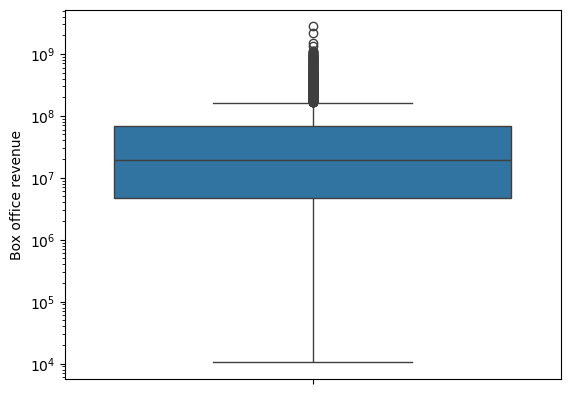

In [99]:
import seaborn as sns 

sns.boxplot(data=Non_zero_Violent_Movies["Box office revenue"])
plt.yscale('log')

In [100]:
Non_zero_Violent_Movies["Box office revenue"].describe()

count    3.250000e+03
mean     7.004543e+07
std      1.470736e+08
min      1.047400e+04
25%      4.662450e+06
50%      1.935608e+07
75%      6.836455e+07
max      2.782275e+09
Name: Box office revenue, dtype: float64

Cofounder : "Box office" refers to total ticket sale revenues, and doesn't include revenues from streaming/VoD/etc. (which could be any amount and are usually unknown). 

0. 1991-2020 pour FBI data, ... pour GVD data
1. stantardiser les box-office 
2. plot les films au cours des années qui ont un box office au-dessus de la médianne
3. plot le genre qui ont le plus de box office 
4. plot le genre qui est le plus représenté dans les violent data (piechart)
5. plot les categories qui le plus représenté dans les violent data (piechart)
6. extract the words the most said in the summaries of the violent data 
7. plot the occurences of the words in the violent data 
8. Trouver unemployment data
9. Visualiser throughout the years real data (GVD, FBI)

In [110]:
Non_zero_Violent_Movies["Release date"] = Non_zero_Violent_Movies["Release date"].str[:4]
Non_zero_Violent_Movies.sort_values(by="Release date", inplace=True)

/tmp/ipykernel_5264/1829191208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Non_zero_Violent_Movies["Release date"] = Non_zero_Violent_Movies["Release date"].str[:4]
/tmp/ipykernel_5264/1829191208.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Non_zero_Violent_Movies.sort_values(by="Release date", inplace=True)


Add the category

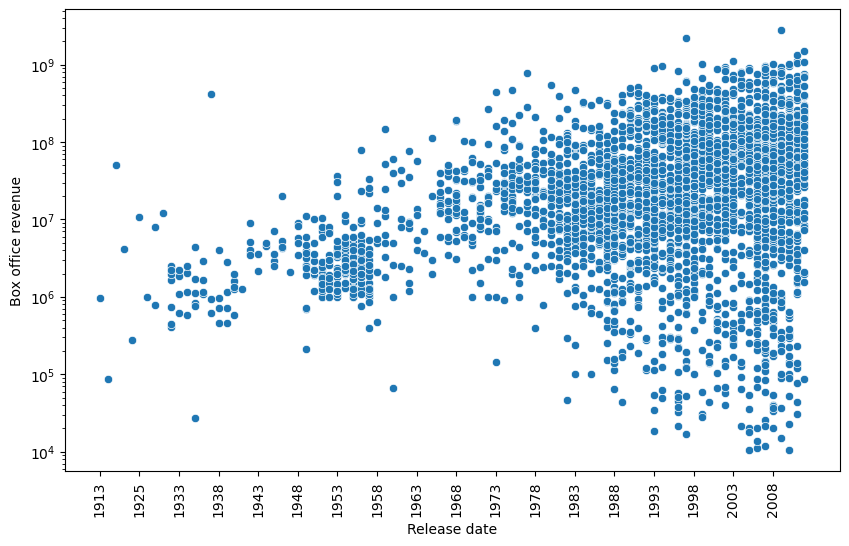

In [115]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Non_zero_Violent_Movies, x="Release date", y="Box office revenue")
plt.yscale('log')
# Rotating X-axis labels
plt.xticks(ticks=range(0, len(Non_zero_Violent_Movies["Release date"].unique()), 5),rotation = 90)
plt.show()
